In [1]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass

import DeepStrain.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util
from utils import myocardial_strain_zc

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' ))

In [2]:
# find patinet_list
patient_list = spreadsheet.iloc[0:50]
patient_index = 0

ID_0692 1 8
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 12
(229, 272, 10)
M shape:  (128, 128, 10)


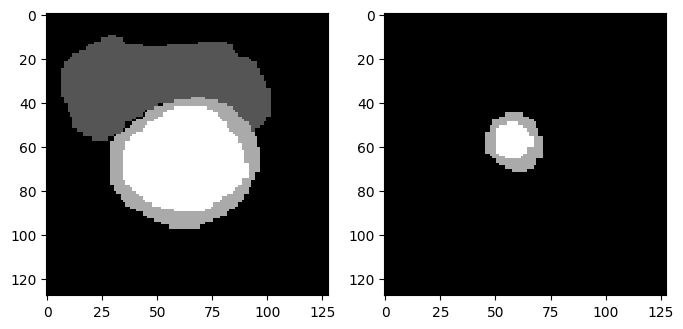

In [3]:
# first: get the ED and ES frame
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES_by_visual'].values[0].astype(int)
print(patient_id, ED,ES)

save_folder = os.path.join(main_path, 'results/geometry/', patient_id)
ff.make_folder([save_folder])

# second: load img and seg
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))

M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))


# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
new_M_ED = np.zeros_like(M_ED)
new_M_ED[M_ED_RV==3] = 1
new_M_ED[M_ED==1] = 3
new_M_ED[M_ED==2] = 2

# fourth: find the number of non-zero slices (that has LV + myocardium segmentation)
slice_nonzero_ed = [i for i in range(new_M_ED.shape[2]) if np.sum(new_M_ED[:,:,i] > 1)>0]
print(slice_nonzero_ed, len(slice_nonzero_ed))
new_M_ED = new_M_ED[:,:,slice_nonzero_ed]
new_M_ED_nifti = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

# fifth: resample the image to a uniform number of slices
new_M_ED_nifti = resample_nifti(new_M_ED_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=10)
print(new_M_ED_nifti.get_fdata().shape)

# sixth: crop
center = center_of_mass(new_M_ED_nifti.get_fdata()>1) # RV = 1, Myocardium = 2, LV = 3
M = _roll2center_crop(x=new_M_ED_nifti.get_fdata(), center=center)
print('M shape: ', M.shape)

# seventh: make it start from the base
start_slice = np.copy(M[:,:,1]); start_slice[start_slice >0] = 1
end_slice = np.copy(M[:,:,-2]); end_slice[end_slice >0] = 1
if np.sum(start_slice) < np.sum(end_slice):
    start_slice_name = 'apex'
else:
    start_slice_name = 'base'
if start_slice_name == 'apex':
    M = M[:,:,::-1]

plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(M[:,:,0], cmap='gray')
plt.subplot(122); plt.imshow(M[:,:,-1], cmap='gray')

# eighth: save the image
nb.save(nb.Nifti1Image(M, affine=new_M_ED_nifti.affine, header=new_M_ED_nifti.header), os.path.join(save_folder, 'SAX_ED_seg_for_geometry.nii.gz'))

# calculate the circularity index per slice

In [5]:
M_lv = np.copy(M); M_lv[M_lv != 3] = 0; M_lv[M_lv == 3] = 1
M_lv = M_lv.astype(np.int)
circular_index_img = util.circularity_index_img(M_lv, range(0,10))

# calculate the center dis

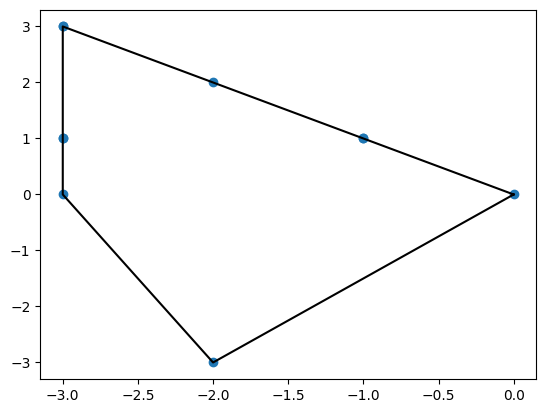

Area of Convex Hull: 9.0
enclosed_area:  9.0


In [6]:
centers_delta, centers = util.get_centers(M_lv, range(0,10), make_plot = False)
centers_delta_neighbouring = centers_delta[1:] - centers_delta[:-1]
enclosed_area = util.centers_enclosed_area(centers_delta, make_plot = True)
print('enclosed_area: ', enclosed_area)

# calculate the major and minor axis of each slice as well as the whole volume

In [8]:
from skimage.measure import label, regionprops
# per slice:
axis_len = []
for z in range(0, M_lv.shape[-1]):
    img_slice = M_lv[:,:,z]
    major, minor = util.major_minor_axis_len(img_slice)
    axis_len.append([major, minor])
major, _ = util.major_minor_axis_len(M_lv) # 3D
axis_len.append([major, 10])
axis_len = np.asarray(axis_len)


# get skeleton

In [20]:
patient_index = 1

In [21]:
# load data
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES_by_visual'].values[0].astype(int)
print(patient_id, ED,ES)

seg_ed = nb.load(os.path.join(main_path,'results/geometry/', patient_id, 'SAX_ED_seg_for_geometry.nii.gz')).get_fdata()
print(seg_ed.shape)


# rotate the data
plt.figure(figsize=(8,4))
insertion_points = np.load(os.path.join(main_path, 'results/strain', patient_id, 'insertion_points.npy'))
insertion_p1 = insertion_points[0,:]
insertion_p2 = insertion_points[1,:]

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(seg_ed, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)

slice_info = np.load(os.path.join(main_path, 'results/strain', patient_id, 'ED_ES_by_visual/slice_info.npy'), allow_pickle = True)
slice_effective = slice_info[0]

rotate_f = myocardial_strain_zc.Rotate_data(seg_ed, seg_ed, seg_ed, insertion_p1, insertion_p2, non_slice_num = np.arange(0,10))
_,_,seg_ed_rot, ID = rotate_f.rotate_orientation(for_visualization = True)

# plt.figure(figsize=(6,3))
# plt.subplot(121); plt.imshow(seg_ed[:,:,3], cmap='gray')
# plt.subplot(122); plt.imshow(seg_ed_rot[:,:,3], cmap='gray')
# plt.show()





ID_1207 1 6
(128, 128, 10)
phi_angle:  98.63267880345018


<Figure size 800x400 with 0 Axes>

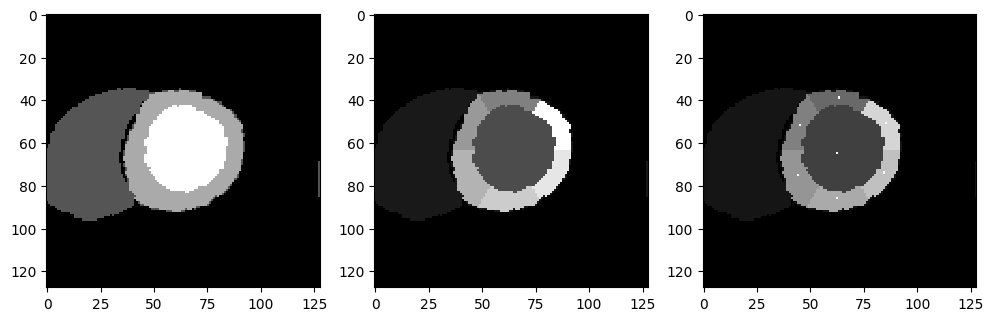

In [22]:
# get center for each AHA segment
aha_center_extractor = myocardial_strain_zc.Find_AHA_segment_centers(seg_ed_rot)
E_aha = aha_center_extractor.assign_different_values_for_each_aha()
aha_center_list_int, aha_center_list_decimals, E_aha_w_centers = aha_center_extractor.find_aha_segment_centers(E_aha)


# get centerline

slice_center_list_int = np.zeros([10,3])
slice_center_list_decimals = np.zeros([10,3])

for slice_n in range(0,10):
    E_slice = np.copy(seg_ed_rot[:,:,slice_n]) == 2
    center_specific_slice = center_of_mass(E_slice)
    center_x = center_specific_slice[0]
    center_y =  center_specific_slice[1]

    slice_center_list_int[slice_n, 0] = int(np.round(center_x))
    slice_center_list_int[slice_n, 1] = int(np.round(center_y))
    slice_center_list_int[slice_n, 2] = slice_n

    slice_center_list_decimals[slice_n, 0] = center_x
    slice_center_list_decimals[slice_n, 1] = center_y
    slice_center_list_decimals[slice_n, 2] = slice_n


for slice_center in slice_center_list_int:
    E_aha_w_centers[int(slice_center[0]), int(slice_center[1]), int(slice_center[2])] = 12


plt.figure(figsize=(12,4))
slice_n = 4
plt.subplot(131); plt.imshow(seg_ed_rot[:,:,slice_n], cmap='gray')
plt.subplot(132); plt.imshow(E_aha[:,:,slice_n], cmap='gray')
plt.subplot(133); plt.imshow(E_aha_w_centers[:,:,slice_n], cmap='gray')

In [23]:
import plotly.graph_objs as go
import numpy as np


# Extract x, y, z coordinates for centerline
x1, y1, z1 = slice_center_list_decimals[:, 0], slice_center_list_decimals[:, 1], abs(slice_center_list_decimals[:, 2] - 9)
trace1 = go.Scatter3d(x=x1, y=y1, z=z1, mode='lines+markers', marker=dict(size=5), line=dict(color='blue'))

# do line between each center point and aha center point
trace = [trace1]
for i in range(0,  aha_center_list_decimals.shape[0]):
    z_value = int(aha_center_list_int[i, 2])
    row_index_in_centerline = np.where(slice_center_list_int[:, 2] == z_value)[0]
    aha_point = aha_center_list_decimals[i,:].reshape(1,-1)
    center_point = slice_center_list_decimals[row_index_in_centerline,:][0].reshape(1,-1)

    # cancatenate these two points into two rows
    x2 = np.concatenate((aha_point, center_point), axis = 0)

    ttrace = go.Scatter3d(x=x2[:, 0], y=x2[:, 1], z=abs(x2[:, 2] - 9), mode='lines+markers', marker=dict(size=5), line=dict(color='red'))
    trace.append(ttrace)


# Create a figure and add the traces
fig = go.Figure(data=trace)

# Set layout options and z-axis ticks
fig.update_layout(scene=dict(xaxis=dict(range=[0,128]), yaxis=dict(range=[0,128]), zaxis=dict(range=[-1, 10], tickvals=list(range(-1, 11)))),
                  scene_aspectmode='manual',  # To fix the aspect ratio
                  width=1000, height=1000,
                  showlegend=False)

# Show the plot
fig.show()
